In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import h5py
from scipy.interpolate import CubicSpline
from scipy.io import savemat
from scipy.interpolate import interp1d
from collections import OrderedDict
%matplotlib inline

In [2]:
df = pd.read_parquet("ASMS-nodes.parquet")
df

S1  \
0    [-0.03639629823712, 0.363365523203351, 0.00944...   
1    [0.125366029263795, -0.38030901219380103, 0.01...   
2    [-0.31602207203862, 0.24499424739325049, 0.012...   
3    [0.31602155815302, 0.2449949092672041, 0.01269...   
4    [-0.01819920434875, -0.43458247698438285, 0.01...   
..                                                 ...   
670  [0.496901570189443, -0.08181493026818662, 0.02...   
671  [0.503452695590093, -0.009443037119758902, 0.0...   
672  [0.499518433603219, 0.06311817631832842, 0.023...   
673  [0.460738174452999, 0.20279117846209022, 0.023...   
674  [0.304725764235315, 0.40050765595964666, 0.023...   

                                                    S2  \
0    [-0.5034526715110165, -0.009802872414338193, 0...   
1    [-0.5027962964556788, 0.026548711257379204, 0....   
2    [-0.5014842787485148, -0.04610705835327708, 0....   
3    [-0.49951857561640567, 0.06275817243140552, 0....   
4    [-0.49690138045148047, -0.08217457343870466, 0...   
..                                                 ...   
670  [0.49690158931219774, -0.08217333989504622, 0....   
671  [0.49951842452227946, 0.06275941247172559, 0.0...   
672  [0.5014843980319794, -0.04610581343282774, 0.0...   
673  [0.5027962352913223, 0.026549959434658016, 0.0...   
674  [0.5034527006294228, -0.009801622607511856, 0....   

                                                    S3  \
0    [-0.036396298237072994, 0.36336552320324766, 0...   
1    [0.12536602926385115, -0.3803090121939021, 0.0...   
2    [-0.31602207203857124, 0.24499424739314324, 0....   
3    [0.3160215581530669, 0.24499490926710454, 0.01...   
4    [-0.018199204348694903, -0.43458247698448477, ...   
..                                                 ...   
670  [0.49690157018949543, -0.08181493026828443, 0....   
671  [0.5034526955901436, -0.009443037119855696, 0....   
672  [0.4995184336032663, 0.06311817631823002, 0.02...   
673  [0.4607381744530491, 0.20279117846199182, 0.02...   
674  [0.3047257642353603, 0.40050765595954474, 0.02...   

                                                    S4  \
0    [-0.5034526715111739, -0.009802872414821187, 0...   
1    [-0.5027962964558499, 0.026548711256896135, 0....   
2    [-0.5014842787486813, -0.04610705835376142, 0....   
3    [-0.4995185756165689, 0.06275817243092197, 0.0...   
4    [-0.4969013804516348, -0.08217457343918788, 0....   
..                                                 ...   
670  [0.49690158931204287, -0.08217333989546345, 0....   
671  [0.4995184245221135, 0.06275941247130759, 0.02...   
672  [0.5014843980318191, -0.046105813433245546, 0....   
673  [0.502796235291159, 0.0265499594342401, 0.0224...   
674  [0.5034527006292607, -0.009801622607930731, 0....   

                                                    S5  \
0    [-0.03639629823719279, 0.36336552320324716, 0....   
1    [0.12536602926372917, -0.38030901219390206, 0....   
2    [-0.3160220720386931, 0.24499424739314332, 0.0...   
3    [0.3160215581529466, 0.24499490926710255, 0.01...   
4    [-0.0181992043488155, -0.43458247698448405, 0....   
..                                                 ...   
670  [0.49690157018937364, -0.08181493026828501, 0....   
671  [0.5034526955900238, -0.009443037119857722, 0....   
672  [0.49951843360315007, 0.06311817631822905, 0.0...   
673  [0.46073817445292686, 0.20279117846199052, 0.0...   
674  [0.3047257642352422, 0.4005076559595452, 0.023...   

                                                    S6  \
0    [-0.50345267151135, -0.009802872414010233, 0.0...   
1    [-0.5027962964560037, 0.026548711257706387, 0....   
2    [-0.5014842787488606, -0.046107058352951036, 0...   
3    [-0.4995185756167104, 0.06275817243173137, 0.0...   
4    [-0.4969013804518366, -0.0821745734383898, 0.0...   
..                                                 ...   
670  [0.4969015893118496, -0.08217333989501019, 0.0...   
671  [0.4995184245219696, 0.06275941247176084, 0.02...   
672  [0.501484398031637, -0.04610581343279324

In [3]:
from dataclasses import dataclass
@dataclass
class CeoKl:
    D: float
    radius2: np.ndarray
    radialFun: np.ndarray
    nv: float
    azimOrder: np.ndarray
    CEO_KL: list

In [4]:
def ceo_modes(filename):

    data = h5py.File(filename,'r')
    print('HDF5 data sets:',list(data.keys()))

    nv = int(data['nv'][()])
    print(' . # of radial function: {0:d}'.format(nv))
    na = int(data['na'][()])
    print(' . azimuth sampling: {0:d}'.format(na))
    nf = int(data['nf'][()])
    print(' . # of modes: {0:d}'.format(nf))
    azimOrder = data['azimOrder'][()]
    angle = data['angle'][()]
    radialFun = data['radialFun'][()]
    NRF = np.std(radialFun,1)
    print("Radial function norm: [max,min,mean]:",NRF.max(),NRF.min(),NRF.mean())
    radius2 = data['radius2'][()]
    D = data['tel']['D'][()][0]
    data.close()

    Ni = 256
    u = np.linspace(-1,1,Ni)*0.5*1.05
    xi,yi = np.meshgrid(u,u)
    ri2 = np.hypot(xi,yi)**2
    mask = 4*ri2<D
    oi = np.arctan2(yi,xi)

    print('\n * interpolating ...')
    CEO_KL = []
    for k in range(nv):
        print('\r mode #{0:03d}'.format(k),end='')
        rf = interp1d(radius2,radialFun[k,:],kind='cubic',fill_value='extrapolate')(ri2)
        m = azimOrder[k]
        if m==0:
            CEO_KL += [rf]
        else:
            CEO_KL += [rf*np.cos(m*oi),rf*np.sin(m*oi)]

    return CeoKl(D,radius2,radialFun,nv,azimOrder,CEO_KL)

In [5]:
CEO_KL = {'outer':\
          ceo_modes('/home/rconan/Dropbox/rconan/Desktop/CppAOapi/examples/Karhunen-Loeve_Basis_Outer10415.hdf5'),
          'center':\
          ceo_modes('/home/rconan/Dropbox/rconan/Desktop/CppAOapi/examples/Karhunen-Loeve_Basis_Center10503_OC03945.hdf5')}

HDF5 data sets: ['angle', 'atm', 'azimOrder', 'na', 'nf', 'nr', 'nv', 'radialFun', 'radius2', 'star', 'tel', 'varCoef']
 . # of radial function: 511
 . azimuth sampling: 2048
 . # of modes: 1000
Radial function norm: [max,min,mean]: 0.9999999999979869 0.007547693361480036 0.9533704029353189

 * interpolating ...
 mode #510HDF5 data sets: ['angle', 'atm', 'azimOrder', 'na', 'nf', 'nr', 'nv', 'radialFun', 'radius2', 'star', 'tel', 'varCoef']
 . # of radial function: 507
 . azimuth sampling: 2048
 . # of modes: 1000
Radial function norm: [max,min,mean]: 0.9999999999969068 0.006085998089611685 0.942104531209059

 * interpolating ...
 mode #506

(-0.1, 0.1)

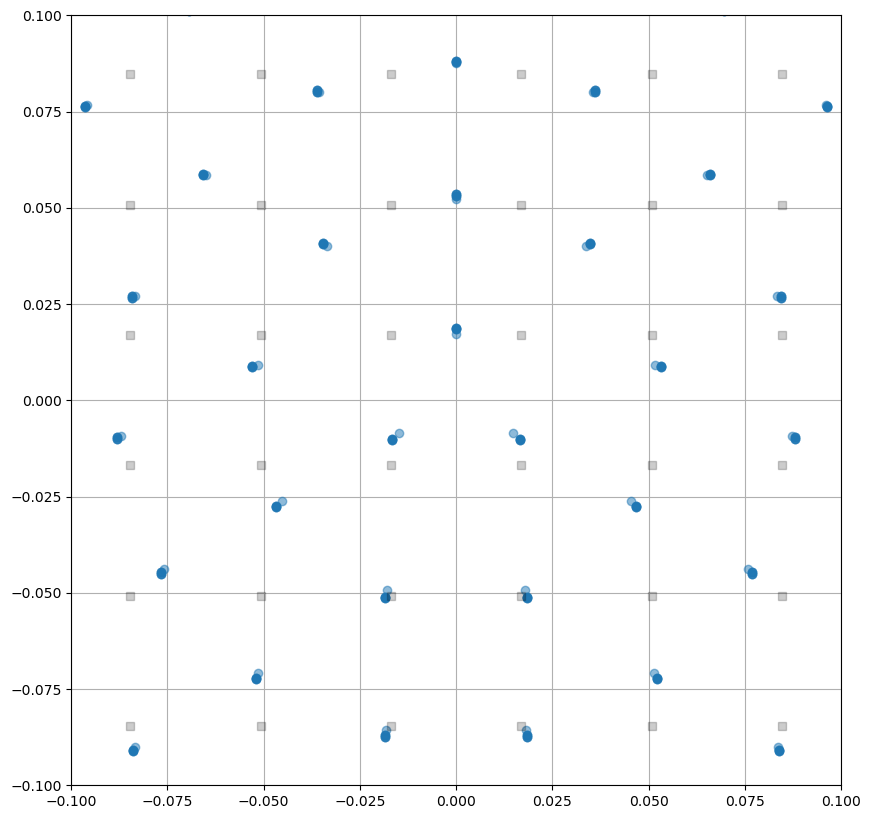

In [29]:
fig,ax = plt.subplots(figsize=(10,10))
for i in range(1,8):
    xyz = np.vstack(df[f'S{i}'])
    ax.plot(xyz[:,0],xyz[:,1],'C0o',alpha=0.5)
o = np.linspace(0,2*np.pi,101)
(xl,yl) = (np.cos(o),np.sin(o))
D = CEO_KL['outer'].D
ax.plot(xl*D/2,yl*D/2,"C3")
D = CEO_KL['center'].D
ax.plot(xl*D/2,yl*D/2,"C3")
ax.set_aspect('equal')
ax.grid()

Ni = 32
u = np.linspace(-1,1,Ni)*0.5*1.05
xi,yi = np.meshgrid(u,u)
ax.plot(xi,yi,'ks',alpha=0.2);

ax.set_xlim(np.asarray([-1,1])*0.1)
ax.set_ylim(np.asarray([-1,1])*0.1)

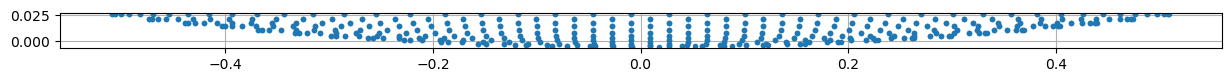

In [22]:
fig,ax = plt.subplots(figsize=(15,10))
ax.plot(xyz[:,1],xyz[:,2],'.')
ax.set_aspect('equal')
ax.grid()

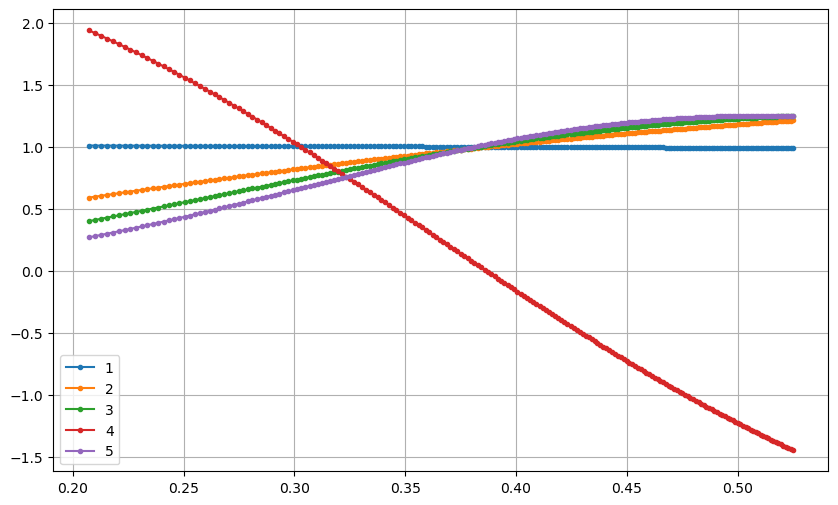

In [23]:
fig,ax=plt.subplots(figsize=(10,6))
ax.plot(np.sqrt(CEO_KL['center'].radius2),CEO_KL['center'].radialFun[:5,:].T,'.-')
ax.grid()
ax.legend(range(1,6))

In [24]:
np.sqrt(CEO_KL['center'].radius2)[-1]*3.6/8.365,np.sqrt(CEO_KL['center'].radius2)[0]

(0.22600597728631203, 0.20717167500000003)

In [7]:
def fem_modes(n, data: CeoKl):
    modes = {f"KL_{i}":[] for i in range(1,8)} 
    for i in range(1,8):
        xyz = np.vstack(df[f'S{i}'])
        xi = xyz[:,0]
        yi = xyz[:,1]
        r2 = xi**2+yi**2
        oi = np.arctan2(yi,xi)
        KL = []
        l = 0
        for k in range(data.nv):
            cs = CubicSpline(data.radius2,data.radialFun[k])
            rf = cs(r2)
            m = data.azimOrder[k]
            if m==0:
                KL += [rf]
                if i==1:
                    data.CEO_KL[l] /= np.sqrt(np.sum(KL[-1]**2))
                l += 1
                KL[-1] /= np.sqrt(np.sum(KL[-1]**2))
            else:
                KL += [rf*np.cos(m*oi),rf*np.sin(m*oi)]
                if i==1:
                    data.CEO_KL[l] /= np.sqrt(np.sum(KL[-2]**2))
                l += 1
                KL[-2] /= np.sqrt(np.sum(KL[-2]**2))
                if i==1:
                    data.CEO_KL[l] /= np.sqrt(np.sum(KL[-1]**2))
                l += 1
                KL[-1] /= np.sqrt(np.sum(KL[-1]**2))
        #L = np.diag(1/np.sqrt(np.diag(B@B.T)))
        #B = L@B
        modes[f"KL_{i}"] = np.vstack(KL)[:n,:].T
    return modes

In [8]:
n = 496
modes = {k:fem_modes(n,CEO_KL[k]) for k in ['outer','center']}

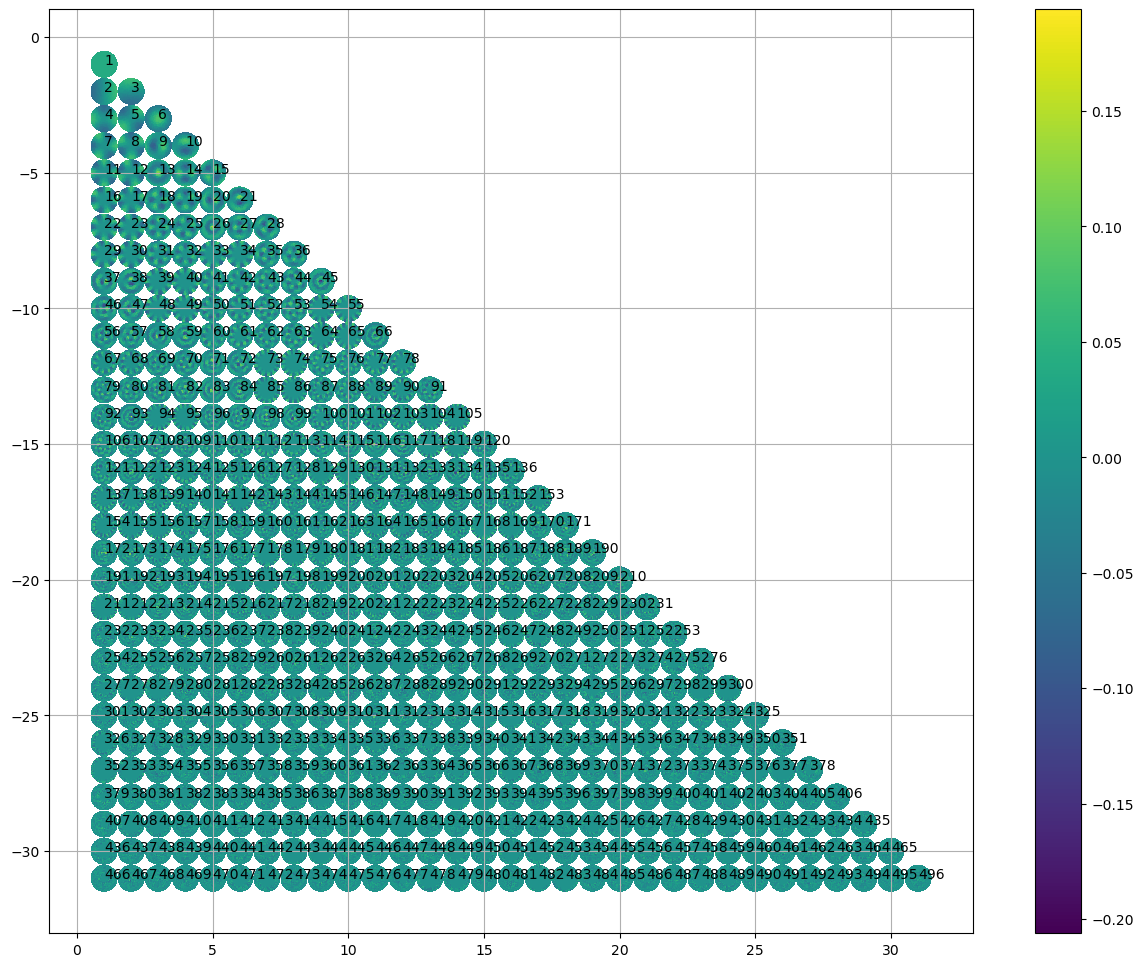

In [27]:
i = 4
KL = modes['outer'][f"KL_{i}"]
xyz = np.vstack(df[f'S{i}'])
xi = xyz[:,0]
yi = xyz[:,1]
vmin = KL[:n,:].min()
vmax = KL[:n,].max()
fig,ax = plt.subplots(figsize=[16,12])
k = 0
for i in range(31):
    for j in range(0,i+1): 
        h=ax.tripcolor(xi/D+j+1,yi/D-i-1,KL[:,k],vmin=vmin,vmax=vmax)
        k += 1
        ax.text(j+1,-i-1,f'{k}')
ax.set_aspect('equal')
ax.grid()
fig.colorbar(h,ax=ax)


(-0.377533818334548,
 19.382690919946022,
 -18.332703960733692,
 0.3330198592796747)

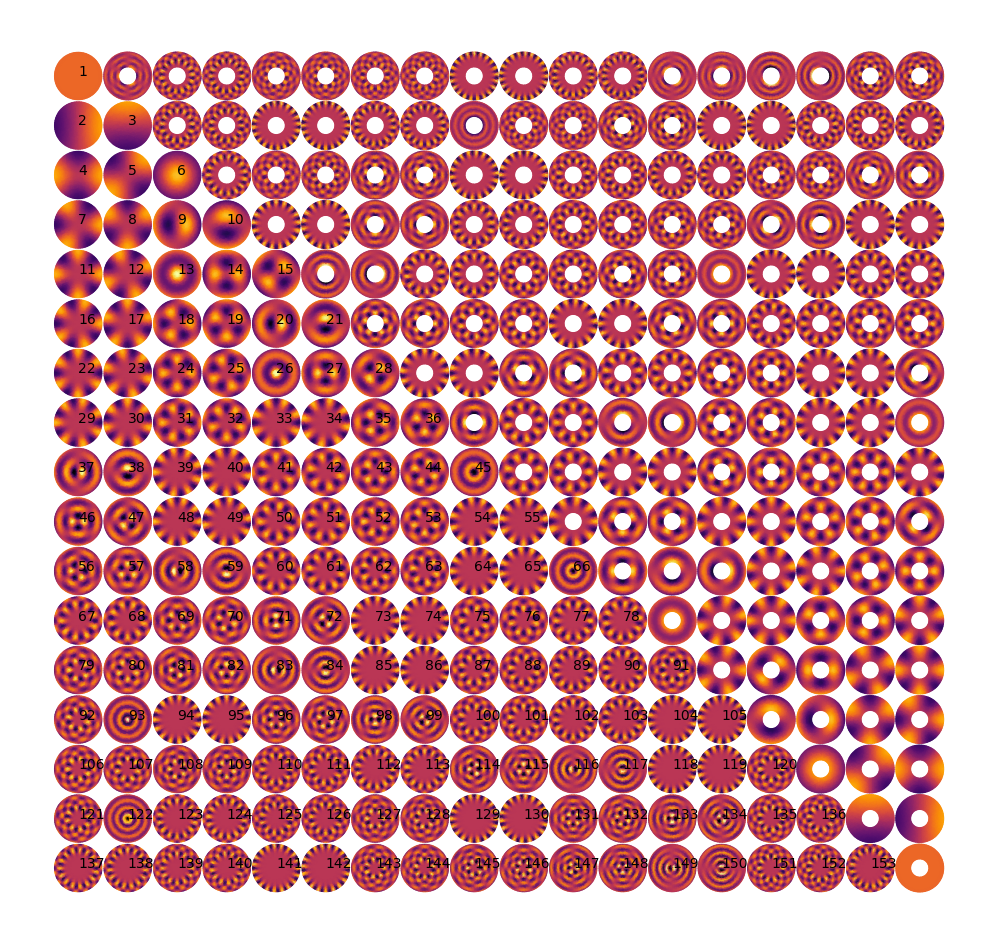

In [10]:
i = 7
KLc = modes['center'][f"KL_{i}"]
xyz = np.vstack(df[f'S{i}'])
xic = xyz[:,0]
yic = xyz[:,1]

i = 1
KLo = modes['outer'][f"KL_{i}"]
xyz = np.vstack(df[f'S{i}'])
xio = xyz[:,0]
yio = xyz[:,1]

nn = 153
vmin = KLo[:nn,:].min()
vmax = KLo[:nn,].max()
vmin = min(vmin,KLc[:nn,:].min())
vmax = max(vmax,KLc[:nn,].max())

fig,ax = plt.subplots(figsize=[16,12])
k = 0
for i in range(17):
    for j in range(0,i+1): 
        triang_c = tri.Triangulation(xic/D+17-j+1,yic/D-17+i)
        triang_c.set_mask(np.hypot(((xic[triang_c.triangles])).mean(axis=1),
                         ((yic[triang_c.triangles])).mean(axis=1))
                < 0.2)
        h=ax.tripcolor(triang_c,KLc[:,k],vmin=vmin,vmax=vmax, shading='gouraud', cmap='inferno')
        triang_o = tri.Triangulation(xio/D+j+1,yio/D-i-1)
        h=ax.tripcolor(triang_o,KLo[:,k],vmin=vmin,vmax=vmax, shading='gouraud', cmap='inferno')
        k += 1
        ax.text(j+1,-i-1,f'{k}')
ax.set_aspect('equal')
ax.grid()
#fig.colorbar(h,ax=ax)
ax.axis('off')

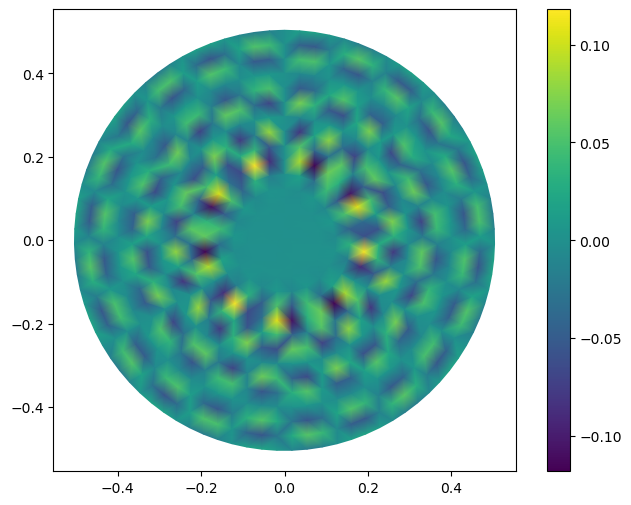

In [26]:
l = 5
fig,ax = plt.subplots(figsize=[8,6])
h=ax.tripcolor(xio,yio,KLo[:,347],shading='gouraud')
ax.set_aspect("equal")
fig.colorbar(h,ax=ax)

In [114]:
0.039*2*1e3

78.0

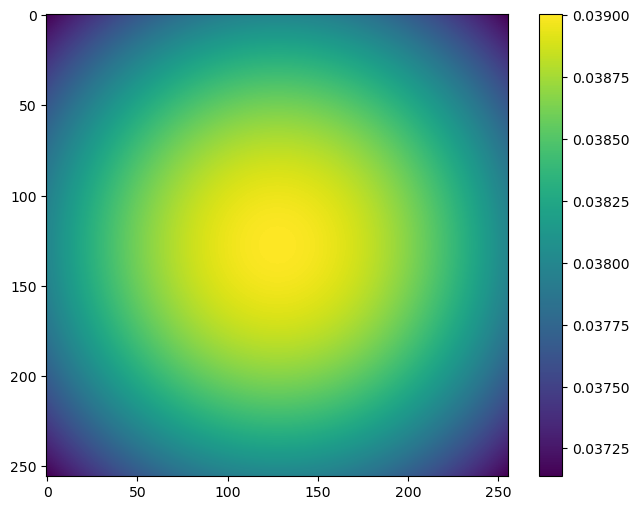

In [30]:
fig,ax = plt.subplots(figsize=[8,6])
h=ax.imshow(CEO_KL['outer'].CEO_KL[0])
ax.set_aspect("equal")
fig.colorbar(h,ax=ax)

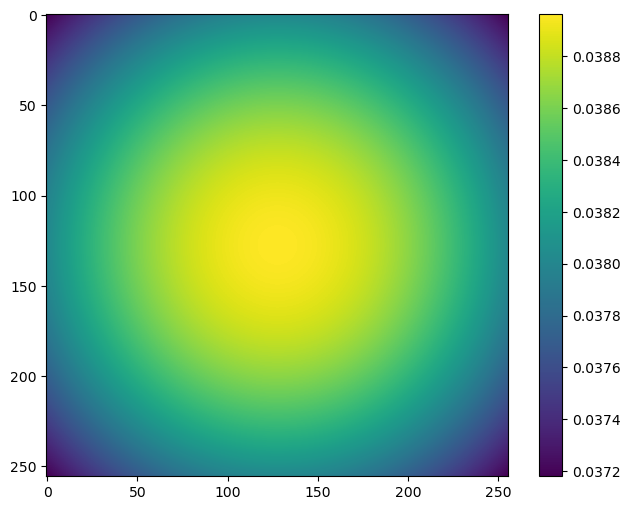

In [31]:
fig,ax = plt.subplots(figsize=[8,6])
h=ax.imshow(CEO_KL['center'].CEO_KL[0])
ax.set_aspect("equal")
fig.colorbar(h,ax=ax)

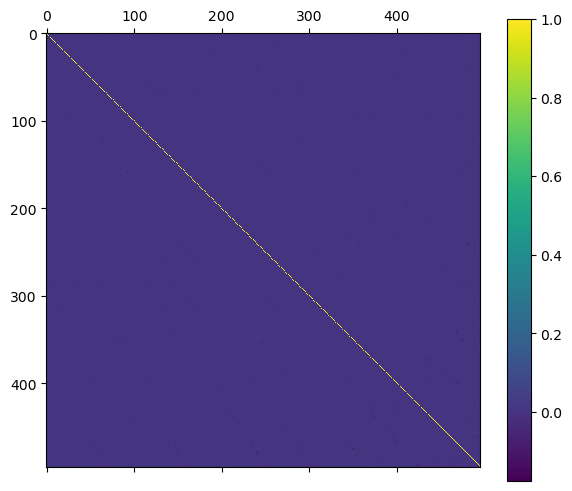

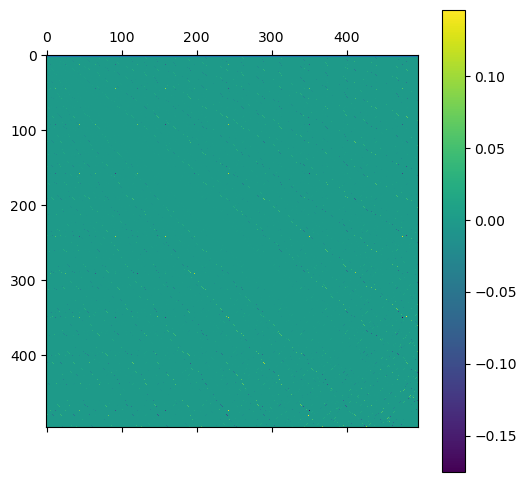

In [68]:
B = modes['outer']["KL_1"]
fig,ax = plt.subplots(figsize=(7,6))
h=ax.matshow(B.T@B)
fig.colorbar(h,ax=ax)
fig,ax = plt.subplots(figsize=(6,6))
h=ax.matshow(B.T@B - np.eye(n))
fig.colorbar(h,ax=ax)
plt.plot(np.diag(B.T@B))

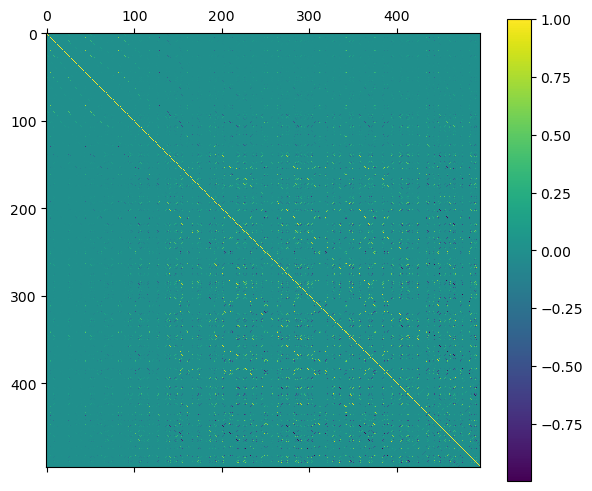

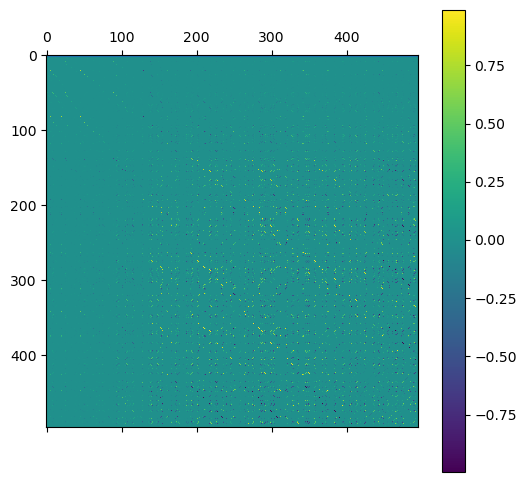

In [71]:
B = modes['center']["KL_7"]
fig,ax = plt.subplots(figsize=(7,6))
h=ax.matshow(B.T@B)
fig.colorbar(h,ax=ax)
fig,ax = plt.subplots(figsize=(6,6))
h=ax.matshow(B.T@B - np.eye(n))
fig.colorbar(h,ax=ax)
plt.plot(np.diag(B.T@B))

In [72]:
pwd

'/home/rconan/Dropbox/projects/dos-actors/grsim/asms'

In [67]:
mixed_modes = modes['outer']
Q, R = np.linalg.qr(modes['center']['KL_7'])
#mixed_modes['KL_7'] = modes['center']['KL_7']
mixed_modes['KL_7'] = Q 
savemat("KLmodesQR.mat",mixed_modes)

In [157]:
modes['center']['KL_7'].shape, Q.shape, R.shape

((675, 496), (675, 496), (496, 496))

In [147]:
Ni = 256
u = np.linspace(-1,1,Ni)*0.5*1.05
xi,yi = np.meshgrid(u,u)

In [148]:
from scipy.interpolate import CloughTocher2DInterpolator,NearestNDInterpolator
xyz = np.vstack(df['S1'])
interp = CloughTocher2DInterpolator(xyz[:,:2], mixed_modes["KL_1"])
zi = interp(xi,yi)
interp = NearestNDInterpolator(xyz[:,:2], mixed_modes["KL_1"])
zin = interp(xi,yi)
nan_idx = np.isnan(zi)
zi[nan_idx] = zin[nan_idx]
outer_zi = zi.copy()

In [149]:
xyz = np.vstack(df['S7'])
interp = CloughTocher2DInterpolator(xyz[:,:2], mixed_modes["KL_7"])
zi = interp(xi,yi)
interp = NearestNDInterpolator(xyz[:,:2], mixed_modes["KL_7"])
zin = interp(xi,yi)
nan_idx = np.isnan(zi)
zi[nan_idx] = zin[nan_idx]
center_zi = zi.copy()

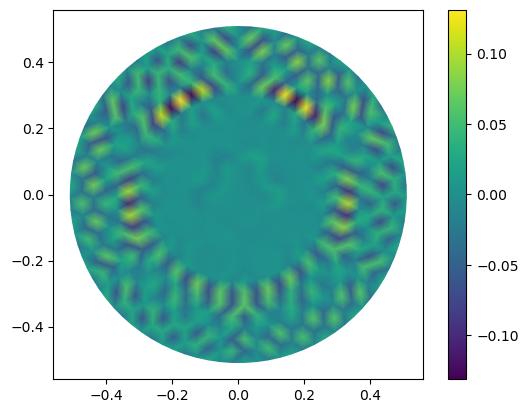

In [150]:
fig,ax = plt.subplots()
h=ax.tripcolor(xic,yic,mixed_modes["KL_7"][:,-1],shading="gouraud")
ax.set_aspect("equal")
fig.colorbar(h,ax=ax)

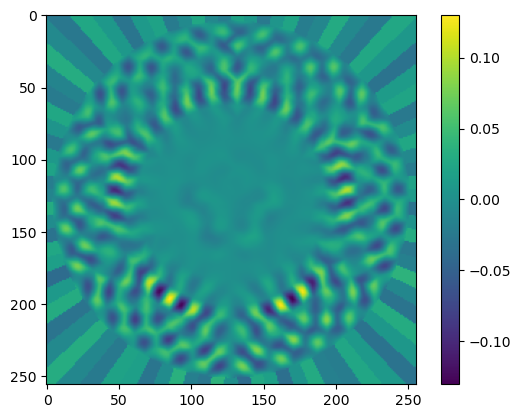

In [151]:
plt.imshow(zi[...,-1])
plt.colorbar()

In [87]:
np.dstack(CEO_KL['outer'].CEO_KL[:n]+CEO_KL['center'].CEO_KL[:n]).shape

(256, 256, 992)

In [154]:
np.dstack(np.dsplit(outer_zi,n)+np.dsplit(center_zi,n)).shape

(256, 256, 992)

In [155]:
suit = OrderedDict()
suit['Ni']     = np.array( 256,     dtype=np.int32)
suit['L']      = np.array( 1.05,     dtype=np.double)
suit['N_SET']  = np.array( 2,     dtype=np.int32)
suit['N_MODE'] = np.array( n,     dtype=np.int32)
suit['s2b']    = np.array( [0]*6+[1], dtype=np.int32)
#suit['M'] = np.dstack(CEO_KL['outer'].CEO_KL[:n]+CEO_KL['center'].CEO_KL[:n]).flatten(order='F')
suit['M'] = np.dstack(np.dsplit(outer_zi,n)+np.dsplit(center_zi,n)).flatten(order='F')
path_to_modes  = 'M2_OrthoNormQR_KarhunenLoeveModes.ceo'
with open(path_to_modes,'w') as f:
    for key in suit:
        suit[key].tofile(f)

In [18]:
suit

OrderedDict([('Ni', array(256, dtype=int32)),
             ('L', array(1.05)),
             ('N_SET', array(2, dtype=int32)),
             ('N_MODE', array(496, dtype=int32)),
             ('s2b', array([0, 0, 0, 0, 0, 0, 1], dtype=int32)),
             ('M',
              array([ 3.71378072e-02,  3.71496134e-02,  3.71613755e-02, ...,
                     -4.47627826e+01, -4.78194842e+01, -5.05154548e+01]))])

In [66]:
modes['center']['KL_7'].shape,Q.shape

((675, 496), (675, 496))

In [122]:
1/np.sqrt(675)

0.03849001794597505

In [123]:
B.shape,B[:,0].mean(),np.sqrt(675)*B[:,0].mean(),

((675, 496), 0.038489026115095845, 0.9999742314778706)

In [63]:
Q, R = np.linalg.qr(modes['center']['KL_7'])

In [64]:
Q.shape,Q[:,0].mean()

((675, 496), -0.03848902611509584)

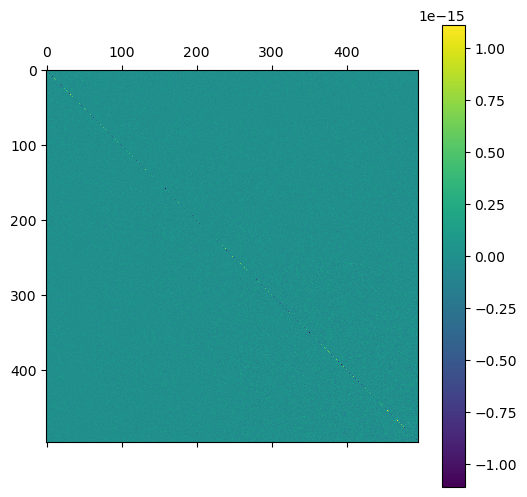

In [158]:
fig,ax = plt.subplots(figsize=(6,6))
h=ax.matshow(Q.T@Q - np.eye(n))
fig.colorbar(h,ax=ax)

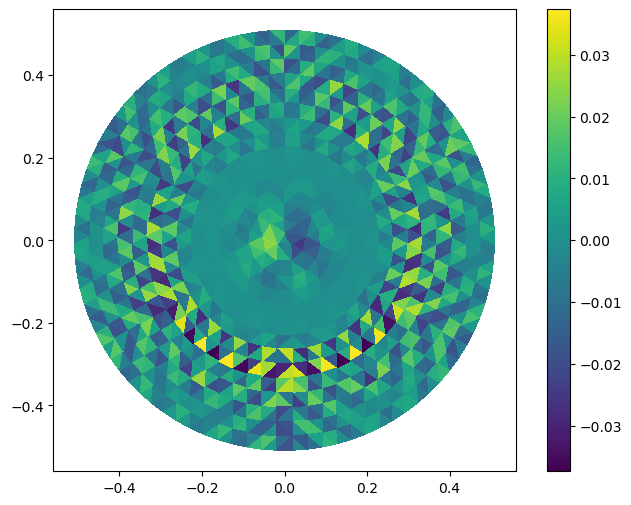

In [58]:
l = -1
fig,ax = plt.subplots(figsize=[8,6])
h=ax.tripcolor(xic,yic,KLc[:,l])
ax.set_aspect("equal")
fig.colorbar(h,ax=ax)

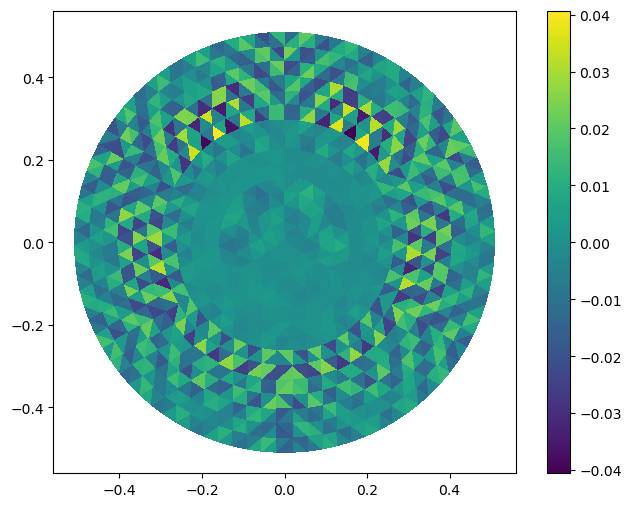

In [57]:
l = -1
fig,ax = plt.subplots(figsize=[8,6])
h=ax.tripcolor(xic,yic,Q[:,l])
ax.set_aspect("equal")
fig.colorbar(h,ax=ax)

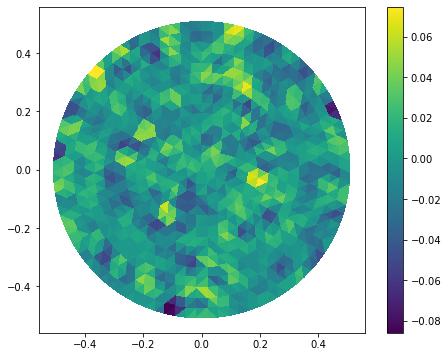

In [42]:
l = -1
fig,ax = plt.subplots(figsize=[8,6])
h=ax.tripcolor(xi,yi,KL[:,l])
ax.set_aspect("equal")
fig.colorbar(h,ax=ax)

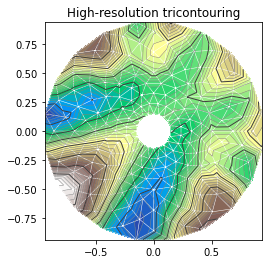

In [43]:
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import numpy as np


# ----------------------------------------------------------------------------
# Analytical test function
# ----------------------------------------------------------------------------
def function_z(x, y):
    r1 = np.sqrt((0.5 - x)**2 + (0.5 - y)**2)
    theta1 = np.arctan2(0.5 - x, 0.5 - y)
    r2 = np.sqrt((-x - 0.2)**2 + (-y - 0.2)**2)
    theta2 = np.arctan2(-x - 0.2, -y - 0.2)
    z = -(2 * (np.exp((r1 / 10)**2) - 1) * 30. * np.cos(7. * theta1) +
          (np.exp((r2 / 10)**2) - 1) * 30. * np.cos(11. * theta2) +
          0.7 * (x**2 + y**2))
    return (np.max(z) - z) / (np.max(z) - np.min(z))

# ----------------------------------------------------------------------------
# Creating a Triangulation
# ----------------------------------------------------------------------------
# First create the x and y coordinates of the points.
n_angles = 20
n_radii = 10
min_radius = 0.15
radii = np.linspace(min_radius, 0.95, n_radii)

angles = np.linspace(0, 2 * np.pi, n_angles, endpoint=False)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
angles[:, 1::2] += np.pi / n_angles

x = (radii * np.cos(angles)).flatten()
y = (radii * np.sin(angles)).flatten()
z = function_z(x, y)

# Now create the Triangulation.
# (Creating a Triangulation without specifying the triangles results in the
# Delaunay triangulation of the points.)
triang = tri.Triangulation(x, y)

# Mask off unwanted triangles.
triang.set_mask(np.hypot(x[triang.triangles].mean(axis=1),
                         y[triang.triangles].mean(axis=1))
                < min_radius)

# ----------------------------------------------------------------------------
# Refine data
# ----------------------------------------------------------------------------
refiner = tri.UniformTriRefiner(triang)
tri_refi, z_test_refi = refiner.refine_field(z, subdiv=3)

# ----------------------------------------------------------------------------
# Plot the triangulation and the high-res iso-contours
# ----------------------------------------------------------------------------
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.triplot(triang, lw=0.5, color='white')

levels = np.arange(0., 1., 0.025)
ax.tricontourf(triang, z, levels=levels, cmap='terrain')
ax.tricontour(triang, z, levels=levels,
              colors=['0.25', '0.5', '0.5', '0.5', '0.5'],
              linewidths=[1.0, 0.5, 0.5, 0.5, 0.5])

ax.set_title("High-resolution tricontouring")

plt.show()